In [26]:
%matplotlib inline  
import matplotlib.pyplot as plt
import tensorflow as tf 
from keras.models import Model
from tensorflow.keras import datasets, layers, models
from keras.layers import Conv2D, Input, multiply, UpSampling2D, Concatenate
from keras.applications.resnet import ResNet101,preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.applications.resnet import ResNet101
from tensorflow.nn import softmax


In [27]:
import os
import numpy as np
import random as rn
from keras import backend as K

#-----------------------------Keras reproducible------------------#
SEED = 1234

tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
rn.seed(SEED)
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
K.set_session(sess)

In [28]:
!wget https://wallpapercave.com/wp/qTcYPPc.jpg

--2021-10-22 15:39:42--  https://wallpapercave.com/wp/qTcYPPc.jpg
Resolving wallpapercave.com (wallpapercave.com)... 172.67.20.199, 104.22.61.71, 104.22.60.71, ...
Connecting to wallpapercave.com (wallpapercave.com)|172.67.20.199|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 304341 (297K) [image/jpeg]
Saving to: ‘qTcYPPc.jpg’

qTcYPPc.jpg         100%[===================>] 297.21K   670KB/s    in 0.4s    

2021-10-22 15:39:44 (670 KB/s) - ‘qTcYPPc.jpg’ saved [304341/304341]



In [29]:
!mv qTcYPPc.jpg dog.jpg

In [30]:
image = load_img('dog.jpg', target_size=(224, 224))
image = img_to_array(image)
image.shape

(224, 224, 3)

In [31]:

# reshape data for the model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
print(image.shape)
# prepare the image for the VGG model
image = preprocess_input(image)
print(image.shape)

(1, 224, 224, 3)
(1, 224, 224, 3)


In [32]:
inputs = Input(shape=(224, 224, 3))
inputs

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_2')>

In [33]:
resnet_model = ResNet101(weights='imagenet',input_tensor=inputs, include_top=False)

In [34]:
#resnet_model.summary()

In [35]:
def conv_bn_relu(input, filters, kernel_size=(3, 3), strides=(2, 2), padding='same'):
  x = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, padding=padding, use_bias=False)(input) 
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  return x

## spatial path

In [36]:
#extracts feature maps that are 1/8 of the original image
def spatial_path(input):
  x = conv_bn_relu(input, 64)
  x = conv_bn_relu(x, 128)
  x = conv_bn_relu(x, 256)
  return x


## context path

In [37]:
def attention_refinement_module(out_channels, input):
  x = layers.GlobalAveragePooling2D(keepdims=True)(input)

  x = layers.Conv2D(filters=out_channels, kernel_size=(1, 1), strides=(1, 1))(x)  

  x = layers.BatchNormalization()(x)
  x = layers.Activation('sigmoid')(x)
  
  x = layers.Multiply()([input, x])

  return x

In [38]:
def feature_fusion_module(num_classes, input1, input2):
  x = layers.Concatenate(axis=-1)([input1,input2])

  feature = conv_bn_relu(x, num_classes, 3, 1)

  x = tf.keras.layers.GlobalAveragePooling2D(keepdims=True)(feature)

  x = layers.Conv2D(filters=num_classes, kernel_size=(1,1), strides=(1,1), use_bias=False)(x)
  x = layers.ReLU()(x)

  x = layers.Conv2D(filters=num_classes, kernel_size=(1,1), strides=(1,1), padding='same', use_bias=False)(x) 
  x = sigmoid(x)

  x = layers.Multiply()([feature, x])

  x = layers.Add()([feature, x]) 

  return x  


In [44]:
def context_path(input):
  features_list = [layer.output for layer in resnet_model.layers]
  activations_model = tf.keras.Model(inputs=resnet_model.input, outputs=features_list)
  activations = activations_model.predict(image)

  layer_names = []
  for layer in resnet_model.layers:
      layer_names.append(layer.name)
  for i, (layer_name, layer_activation) in enumerate(zip(layer_names, activations)):
      if(layer_name == 'conv4_block23_out'):
        feature16 = layer_activation
      if(layer_name == 'conv5_block3_out'):
        feature32 = layer_activation

  tail = tf.math.reduce_mean(feature32, axis=1, keepdims=True)
  tail = tf.math.reduce_mean(tail, axis=2, keepdims=True)

  return feature16, feature32, tail

In [40]:
sp = spatial_path(image)
print("sp.shape: ", sp.shape)

sp.shape:  (1, 28, 28, 256)


In [45]:
cx1, cx2, tail = context_path(image)

In [46]:
print("cx1.shape = ", cx1.shape)
print("cx2.shape = ", cx2.shape)
print("tail.shape = ", tail.shape)

cx1.shape =  (1, 14, 14, 1024)
cx2.shape =  (1, 7, 7, 2048)
tail.shape =  (1, 1, 1, 2048)


In [47]:
cx1 = attention_refinement_module(1024, cx1)
cx2 = attention_refinement_module(2048,cx2)


In [48]:
print("cx1.shape = ",cx1.shape)
print("cx2.shape = ",cx2.shape)

cx1.shape =  (1, 14, 14, 1024)
cx2.shape =  (1, 7, 7, 2048)


In [49]:
#cx2 = multiply([tail,cx2]) #I think this multiply happens after the upsampling
#print("cx2.shape = ", cx2.shape)

In [50]:
# upsampling
cx1 = UpSampling2D(size=2, data_format='channels_last', interpolation='bilinear')(cx1)
cx2 = UpSampling2D(size=4, data_format='channels_last', interpolation='bilinear')(cx2)
print(cx1.shape)
print(cx2.shape)



(1, 28, 28, 1024)
(1, 28, 28, 2048)


In [51]:
cx2 = multiply([tail,cx2]) #I think this multiply happens after the upsampling
print("cx2.shape = ", cx2.shape)

cx2.shape =  (1, 28, 28, 2048)


In [52]:
cx = Concatenate(axis=-1)([cx2, cx1])
print(cx.shape)

(1, 28, 28, 3072)


In [53]:
#result = feature_fusion_module(sp, cx)       
num_classes  =  35
num_positions = 7 #6 character positions and one position for background?
semantic_features = feature_fusion_module(num_classes, sp, cx)
position_features = feature_fusion_module(num_positions, sp, cx) 

In [54]:
print("semantic_result.shape = ", semantic_features.shape)
print("position_result.shape = ", position_features.shape)

semantic_result.shape =  (1, 28, 28, 35)
position_result.shape =  (1, 28, 28, 7)


In [55]:
# upsampling, use for visualization, I don't think the upsampled versions go into shared classifier?
semantic_featuresUP = UpSampling2D(size=8, data_format='channels_last', interpolation='bilinear')(semantic_features)
print("semantic_featuresUP.shape = ", semantic_featuresUP.shape)
position_featuresUP = UpSampling2D(size=8, data_format='channels_last', interpolation='bilinear')(position_features)
print("position_featuresUP.shape = ", position_featuresUP.shape)

semantic_featuresUP.shape =  (1, 224, 224, 35)
position_featuresUP.shape =  (1, 224, 224, 7)


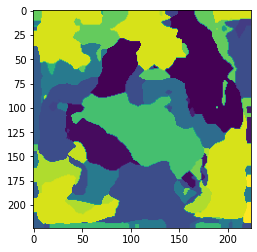

In [56]:
#visualize upsampled semantic and position maps
semantic_result = tf.squeeze(semantic_featuresUP)
semantic_result = tf.argmax(semantic_result, axis=2)
plt.imshow(semantic_result)

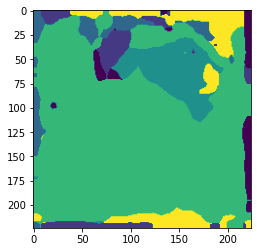

In [57]:
position_result = tf.squeeze(position_featuresUP)
position_result = tf.argmax(position_result, axis=2)
plt.imshow(position_result)

In [ ]:
#final convolution
#I don't think this convolution is needed, but add later if needed
# semantic_result2 = layers.Conv2D(filters=num_classes, kernel_size=1, strides=1)(semantic_features)
# print("semantic_result2.shape = ", semantic_result2.shape)
# position_result2 = layers.Conv2D(filters=num_positions, kernel_size=1, strides=1)(position_features)
# print("position_result2.shape = ", position_result2.shape)

semantic_result2.shape =  (1, 224, 224, 35)
position_result2.shape =  (1, 224, 224, 6)


In [ ]:
#apply softmax to position attention maps and batchNorm to semantic features
pos_att_map = softmax(position_features)
semantic_output = layers.BatchNormalization()(semantic_features)

In [ ]:
#element-wise multiplication, position attention map of each character is used to 
# modulate the semantic features separately
#remove background layer from pos_att_map prior to multiplication (I think this is the last layer?)
for i in range(0,num_positions):
  #multiply ith slice of pos_att_map by some part of semantic_output tensor



In [ ]:
#Shared Classifier:
#5x5 convolution, batch norm, ReLU (verify parameter values later)
#input the result from multiplying semantic_output and pos_att_map
x = conv_bn_relu(input=, filters=idk, kernel_size=(5,5), strides=(1,1), padding='same')(result)
#global pooling
x = layers.GlobalAveragePooling2D(keepdims=True)(x)
#fully connected layer for classification
output = layers.Dense(35)(x)